# 0. Importing dependencies


In [2]:
!pip install opendatasets --upgrade --quiet
!pip install wandb

In [3]:
import os
import pathlib
import time
import datetime

import opendatasets as od

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython import display

import tensorflow as tf

import wandb

2024-03-24 02:30:57.938019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 02:30:57.938123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 02:30:58.110877: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [128]:
config = {
    'img_height': 512,
    'img_width': 512,
    'blurness': 15,
    'gen_type': 2,
    'gen_lr': 2e-4,
    'gen_beta1': 0.5,
    'gen_wd': 0.0,
    'disc_lr': 2e-4,
    'disc_beta1': 0.5,
    'disc_wd': 0.0,
    'lambda': 100
}


wandb.init(project='landscape_generator', config=config)

# 1. Preprocess images

In [8]:
!wget -cO train_test.zip https://www.dropbox.com/scl/fi/zccj9qp8sjk8py5v928xt/landscape_train_test.zip?rlkey=xgipdeeigaq4h9wd6ohmq8slw&dl=0

In [8]:
!unzip train_test.zip

unzip:  cannot find or open train_test.zip, train_test.zip.zip or train_test.zip.ZIP.


In [38]:
dataset_url = 'https://www.kaggle.com/arnaud58/landscape-pictures'

# download landscape dataset
od.download(dataset_url)



Skipping, found downloaded files in "./landscape-pictures" (use force=True to force download)


In [40]:
!ls ./landscape-pictures | head

00000000.jpg
00000000_(2).jpg
00000000_(3).jpg
00000000_(4).jpg
00000000_(5).jpg
00000000_(6).jpg
00000000_(7).jpg
00000001.jpg
00000001_(2).jpg
00000001_(3).jpg
ls: write error: Broken pipe


In [41]:
def plot_image(image, title='Image'):
    plt.figure(figsize = [7, 7])
    plt.title(title)
    plt.axis('off')
    plt.imshow(image[:,:,::-1])

In [42]:
IMG_HEIGHT, IMG_WIDTH = config['img_height'], config['img_width']

def preprocess_image(image):
    # resize image
    image_resized = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))

    # clear image
    image_cleared = cv2.medianBlur(image_resized, config['blurness'])
    image_cleared = cv2.edgePreservingFilter(image_cleared, sigma_s=9)

    return image_resized, image_cleared

def preprocess_image_ls(image_name, path):
    # load image
    image = cv2.imread(f'landscape-pictures/{image_name}')

    # preprocess the image
    image_target, image_input = preprocess_image(image)

    final_image = np.empty((IMG_HEIGHT, 2 * IMG_WIDTH, image.shape[2]))
    final_image[:, :IMG_WIDTH] = image_target
    final_image[:, IMG_WIDTH:] = image_input

    # save image
    cv2.imwrite(f'{path}/{image_name}', final_image)


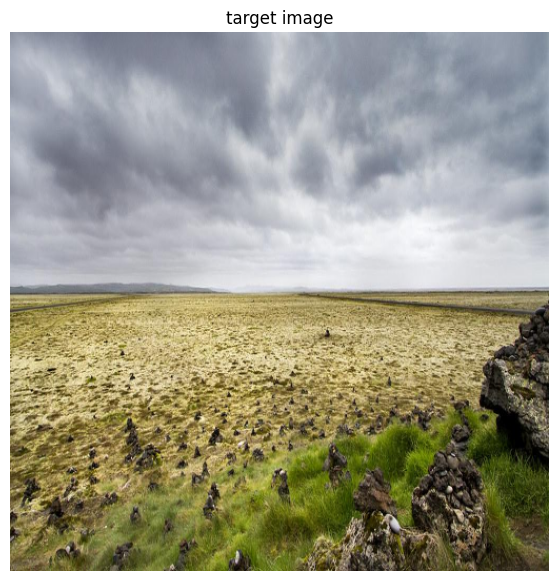

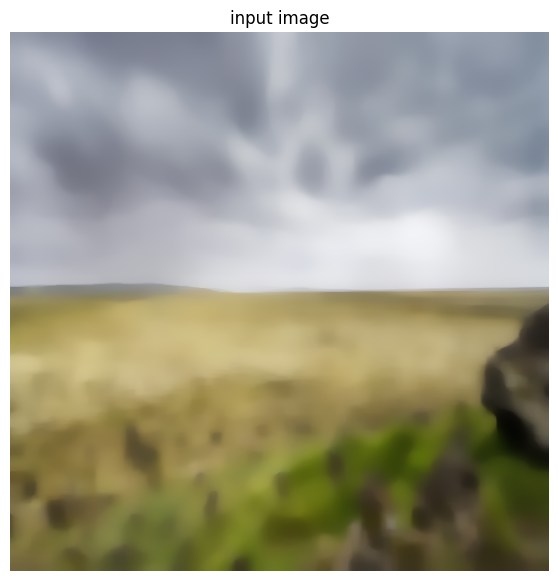

In [91]:
image = cv2.imread(f'landscape-pictures/00000000_(6).jpg')
image_target, image_input = preprocess_image(image)
plot_image(image_target, title='target image')
plot_image(image_input, title='input image')

In [44]:
image_names = os.listdir('landscape-pictures')

if os.path.isdir('train') == False:
    os.mkdir('train')


if os.path.isdir('test') == False:
    os.mkdir('test')

for image_name in image_names:
    if np.random.random() <= 0.1:
        preprocess_image_ls(image_name, 'test')
    else:
        preprocess_image_ls(image_name, 'train')

path = os.getcwd()

In [ ]:
!zip -r train_test.zip train test

# 2. Load data

In [92]:
def load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image
    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

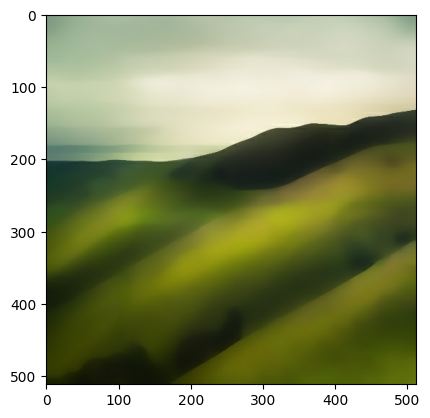

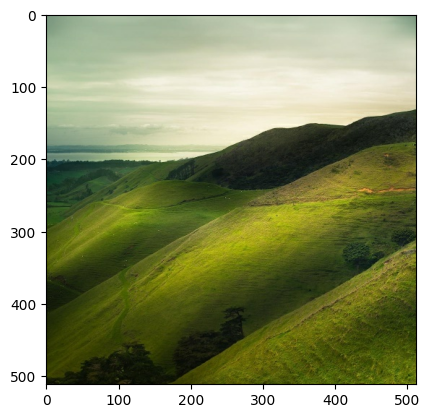

In [93]:
inp, re = load(path + '/train/00000000.jpg')
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [94]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1

## Make image formater methods

Resize method

In [48]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

Random crop on the image

In [49]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

Normalizing the images to `[-1, 1]`


In [50]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [56]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, int(IMG_HEIGHT * 1.15) , int(IMG_WIDTH * 1.15))

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

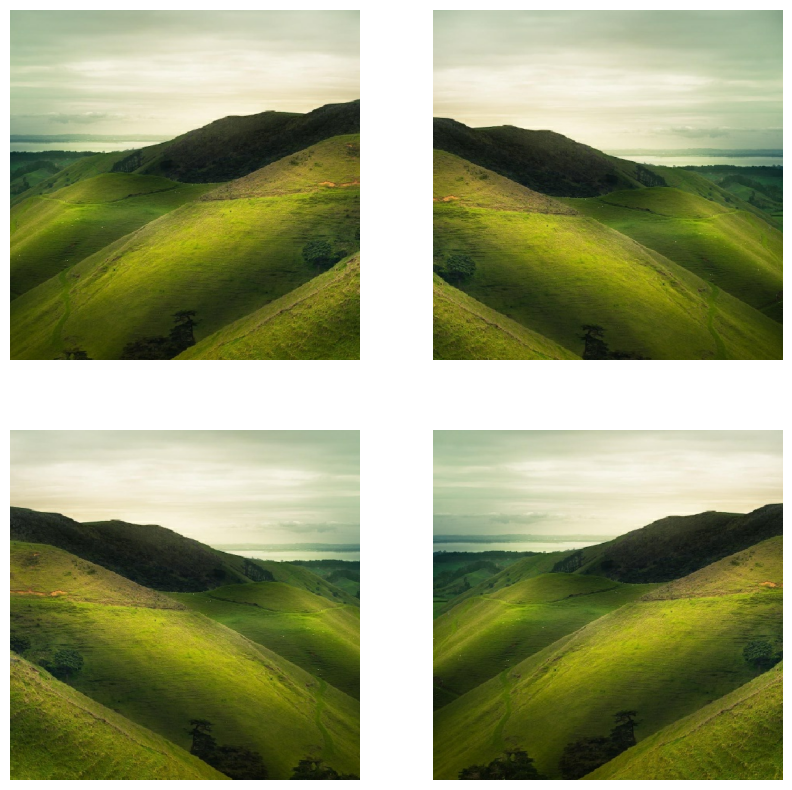

In [57]:
plt.figure(figsize=(10, 10))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_re / 255.0)
    plt.axis('off')
plt.show()

## Make train and test image loader


In [95]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [96]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

## Build an input pipeline with `tf.data`


In [97]:
train_dataset = tf.data.Dataset.list_files(path + '/train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [98]:
test_dataset = tf.data.Dataset.list_files(path + '/test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# 3. Build the model

## Define the generator

Define the downsampler (encoder):

In [99]:
OUTPUT_CHANNELS = 3

In [100]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [101]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 256, 256, 3)


Define the upsampler (decoder):

In [102]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [103]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 512, 512, 3)


Define the generator with the downsampler and the upsampler:

In [104]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [105]:
def Generator2():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(512, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 512)
        downsample(512, 4),  # (batch_size, 64, 64, 512)
        downsample(512, 4),  # (batch_size, 32, 32, 512)
        downsample(256, 4),  # (batch_size, 16, 16, 256)
        downsample(128, 4),  # (batch_size, 8, 8, 128)
        downsample(64, 4),  # (batch_size, 4, 4, 64)
        downsample(32, 4),  # (batch_size, 2, 2, 32)
        downsample(32, 4),  # (batch_size, 1, 1, 32)
    ]

    up_stack = [
        upsample(32, 4, apply_dropout=True),  # (batch_size, 2, 2, 2*32)
        upsample(64, 4, apply_dropout=True),  # (batch_size, 4, 4, 2*64)
        upsample(128, 4, apply_dropout=True),  # (batch_size, 8, 8, 2*128)
        upsample(256, 4),  # (batch_size, 16, 16, 2*256)
        upsample(512, 4),  # (batch_size, 32, 32, 2*512)
        upsample(512, 4),  # (batch_size, 64, 64, 2*512)
        upsample(512, 4),  # (batch_size, 128, 128, 2*512)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [106]:
def Generator3():
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])

    down_stack = [
        downsample(512, 4, apply_batchnorm=False),  # (batch_size, 256, 256, 512)
        downsample(256, 4),  # (batch_size, 128, 128, 256)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(128, 4),  # (batch_size, 32, 32, 128)
        downsample(64, 4),  # (batch_size, 16, 16, 64)
        downsample(64, 4),  # (batch_size, 8, 8, 64)
        downsample(32, 4),  # (batch_size, 4, 4, 32)
        downsample(32, 4),  # (batch_size, 2, 2, 32)
        downsample(16, 4)   # (batch_size, 1, 1, 16)
    ]

    up_stack = [
        upsample(32, 4, apply_dropout=True),  # (batch_size, 2, 2, 2*32)
        upsample(32, 4, apply_dropout=True),  # (batch_size, 4, 4, 2*32)
        upsample(64, 4, apply_dropout=True),  # (batch_size, 8, 8, 2*64)
        upsample(64, 4),  # (batch_size, 16, 16, 2*64)
        upsample(128, 4),  # (batch_size, 32, 32, 2*128)
        upsample(128, 4),  # (batch_size, 64, 64, 2*128)
        upsample(256, 4),  # (batch_size, 128, 128, 2*216)
        upsample(512, 4),  # (batch_size, 256, 256, 2*512)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

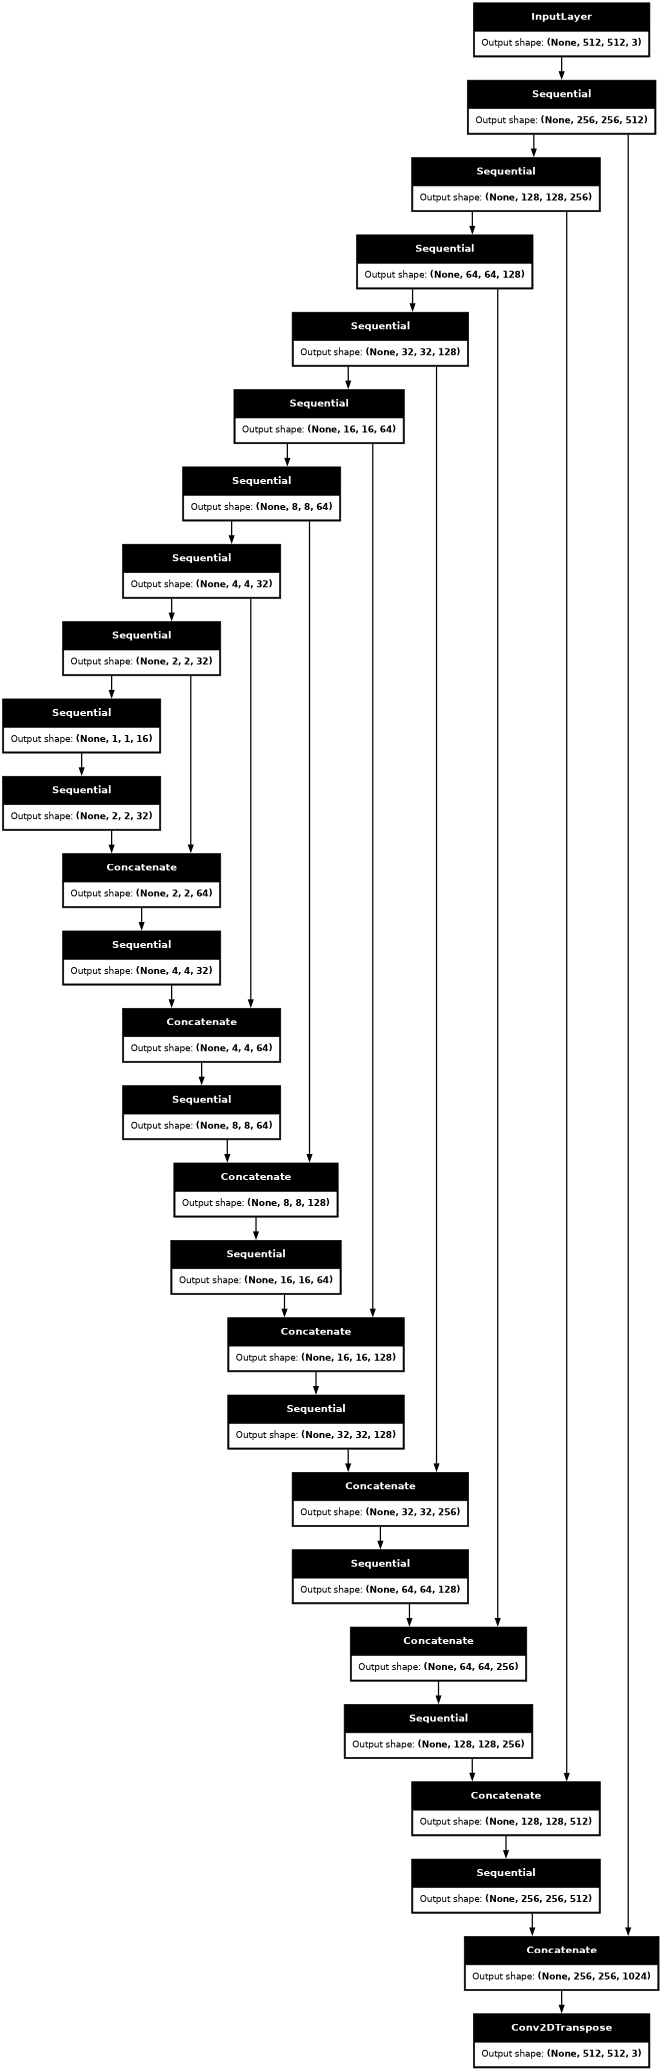

In [107]:
generator = None
if config['gen_type'] == 1:
    generator = Generator()
elif config['gen_type'] == 2 and IMG_HEIGHT == 256:
    generator = Generator2()
elif config['gen_type'] == 2 and IMG_HEIGHT == 512:
    generator = Generator3()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=45)

Test the generator:

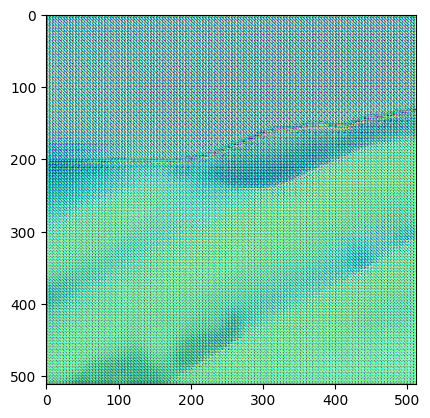

In [108]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

## Define generator loss

In [109]:
LAMBDA = config['lambda']

In [110]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [111]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

## Define the discriminator

In [112]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [113]:
def Discriminator3():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[512, 512, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[512, 512, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 512, 512, channels*2)

    down0 = downsample(32, 4, False)(x)  # (batch_size, 256, 256, 32)
    down1 = downsample(64, 4, False)(down0)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

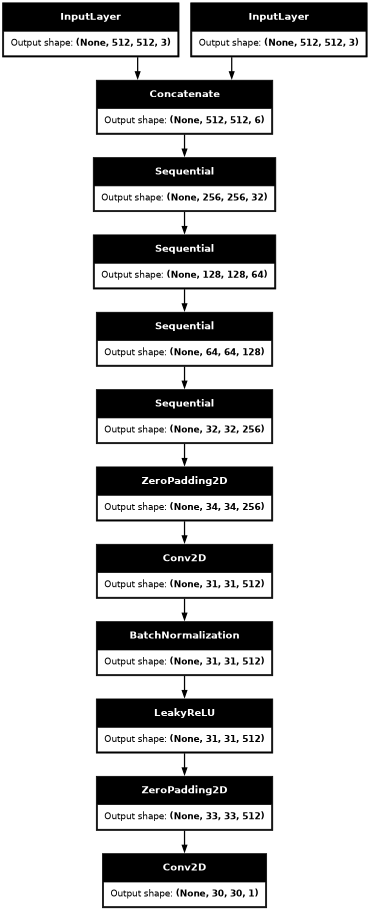

In [114]:
if IMG_HEIGHT == 256:
    discriminator = Discriminator()
elif IMG_HEIGHT == 512:
    discriminator = Discriminator3()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=45)

Test the discriminator:

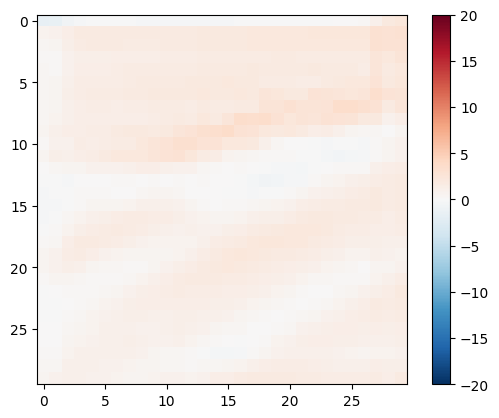

In [115]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

## Define the discriminator loss

In [116]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

## Define the optimizer

In [118]:
generator_optimizer = tf.keras.optimizers.Adam(config['gen_lr'], beta_1=config['gen_beta1'], weight_decay=config['gen_wd'])
discriminator_optimizer = tf.keras.optimizers.Adam(config['disc_lr'], beta_1=config['disc_beta1'], weight_decay=config['disc_wd'])

## Generate and log images


In [119]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [120]:
def log_image(model, test_input, step):
    prediction = model(test_input, training=True)
    wandb.log({"predicted_image": wandb.Image(prediction[0])}, step=step)

In [121]:

def log_images(model, test_ds):
    table = wandb.Table(columns=['input_image', 'ground_truth', 'predicted_image'])
    for example_input, example_target in test_dataset.take(5):
        pred = model(example_input, training=True)
        table.add_data(
            wandb.Image(example_input[0]),
            wandb.Image(example_target[0]),
            wandb.Image(pred[0])
        )
    wandb.log({'sample_images': table})


Test the function:

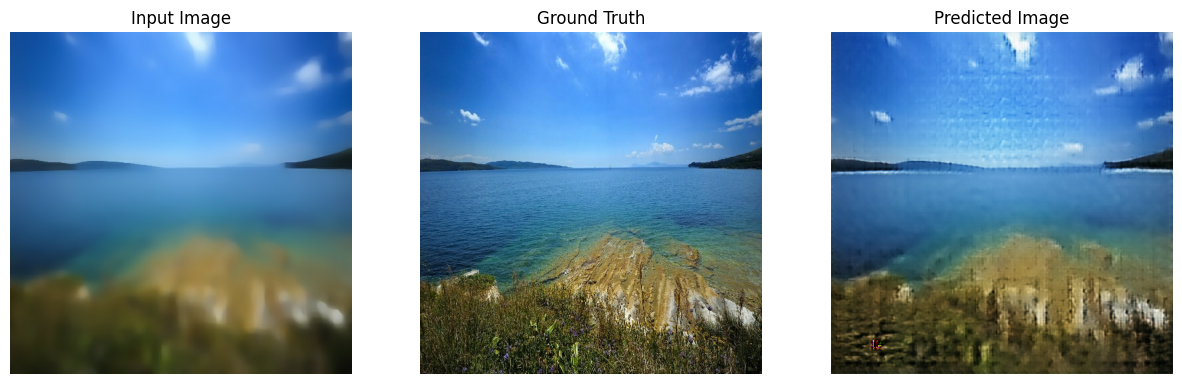

In [129]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

## Model saver

In [123]:
def save_artifact(step):
    gen_art_name = 'generator.keras'
    generator.save(gen_art_name, overwrite=True)
    
    disc_art_name = 'discriminator.keras'
    discriminator.save(disc_art_name, overwrite=True)
    
    gen_at = wandb.Artifact(f'{wandb.run.id}_{gen_art_name}', type='model')
    gen_at.add_file(gen_art_name)
    wandb.log_artifact(gen_at, aliases=[f"step_{step}"])
    
    disc_at = wandb.Artifact(f'{wandb.run.id}_{disc_art_name}', type='model')
    disc_at.add_file(disc_art_name)
    wandb.log_artifact(disc_at, aliases=[f"step_{step}"])
    

# 4. Train

In [124]:
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

@tf.function
def train_step_wrapper(input_image, target, step):
    gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(input_image, target, step)
    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

In [130]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    wandb.log({"input_image": wandb.Image(example_input[0]), "target_image": wandb.Image(example_target[0])})
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            #generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        if step % 1000 == 0:
            log_image(generator, example_input, step)

        # Training step
        gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step_wrapper(input_image, target, step)
        wandb.log({"gen_total_loss": gen_total_loss.numpy(), "gen_gan_loss": gen_gan_loss.numpy(), 'gen_l1_loss': gen_l1_loss.numpy(), 'disc_loss': disc_loss.numpy()}, step=step)
        
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            save_artifact(step)
            log_images(generator, test_dataset)

In [131]:
fit(train_dataset, test_dataset, steps=60000)
log_images(generator, test_dataset)


Time taken for 1000 steps: 307.61 sec

Step: 59k
....................................................................................................

In [132]:
wandb.finish()

disc_loss,▃▁▂▄▁▁▆▁▂▁▁▅▁▁▄▁▅▁▁▁█▂▅▁▁▁▁▁▂▁▁▁▂▇▁▁▂▁▁▂
gen_gan_loss,▂▄▂▁▅▂▁▅█▆▃▆▆▃▁▇█▄▇▄▁▂▅▂▆▃▇▄▂▃▃▅▆▁▅▅▇▇▃▂
gen_l1_loss,▄▂▂▃▅▄▆▁▃▃▂▃▃▆▁▂▄▁▅█▅▅▂▅▂▅▆▆▂▃▅▅▃▄▄▃▁▆▂▆
gen_total_loss,▄▃▂▂▆▄▅▃▆▄▂▅▅▆▁▄▆▂▇█▄▅▄▅▄▅▇▆▂▃▅▆▅▄▅▅▄█▃▆
disc_loss,0.27428
gen_gan_loss,12.32786
gen_l1_loss,0.12625
gen_total_loss,24.95334


## 5. Afterwork